# Contrast Transfer Function
The Contrast Transfer Function (CTF) describes the aberrations of the objective lens in HRTEM and specifies how the condenser system shapes the probe in STEM. Here we describe how to create a CFT with specific aberrations, and how this affects the resulting images.

## Polar expansion of the phase error

Ideally, a lens forms a spherical wave converging on or emerging from a single point. In practice, aberrations cause the wave front to deviate from a spherical surface. This deviation can be represented as a phase error, $\chi(k, \phi)$, of the spatial frequency in polar coordinates. The phase error can be written as a series expansion

$$ 
    \chi(\alpha, \phi) = \frac{2 \pi}{\lambda} \sum_{n,m} \frac{1}{n + 1} C_{n,m} (k \lambda)^{n+1} \cos\left[m (\phi - \phi_{n,m}) \right] \quad ,
$$

where $n,m$ index the different aberrations.

If the microscope is well aligned then off-axis aberrations (astigmatisms) are small and the phase error is dominated by the first two isotropic terms

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f = -C_{1,1}$ is the defocus and $C_s=C_{3,3}$ is the third order spherical aberration.

The `CTF` object takes parameters of the form `Cnm` and `phinm`, and may also be given using their common aliases, e.g. `defocus = -C10`. The expansion is implemented up to 5th order, and all the coefficients labels are shown in the table below.

abTEM exclusively uses polar expansion coefficients; however, a conversion utility from the Cartesian to the polar representation is available in `abtem.transfer.cartesian2polar`.

## Creating a Contrast Transfer Function and applying phase aberrations

We create a `CTF` object with an electron energy of $300 \ \mathrm{keV}$, a spherical aberration of $-7~\mu \mathrm{m}$ (remember that abTEM uses units of Å) and the [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy) (here $-45.5 \ \mathrm{Å}$).

In [1]:
from abtem.transfer import CTF, scherzer_defocus, point_resolution, energy2wavelength
import matplotlib.pyplot as plt
import numpy as np

Cs = -7e-6 * 1e10
ctf = CTF(Cs=Cs, energy=300e3)
ctf.defocus = scherzer_defocus(Cs, ctf.energy)

print(ctf.defocus)

-45.46632087888138


This can also be accomplished by setting the parameters with a dictionary.

In [2]:
parameters = {'C10': - ctf.defocus, 'C30': Cs}
ctf2 = CTF(parameters=parameters, energy=300e3)

We can use the function `plot_ctf` to preview the CTF along a radial direction up to a given angle (in radians).

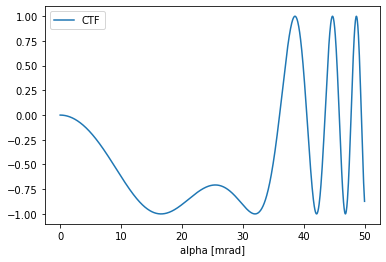

In [3]:
ctf.show(50)

Given the exit wave function $\phi_{exit}$ and the phase error $\chi$, the wave function at the image plane is given by

$$  
    \phi_{image}(\alpha, \phi) = \phi_{exit}(\alpha, \phi) \exp(-i \chi(\alpha, \phi)) \quad .
$$


To perform this operation, we use the `apply_ctf` method. Here we apply the CTF to the exit wave from an earlier tutorial.

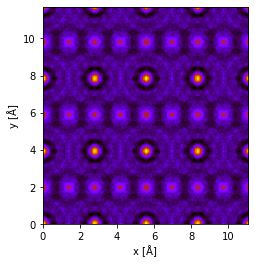

In [4]:
from abtem.waves import Waves

exit_wave = Waves.read('data/srtio3_110_exit_wave.hdf5')
image_wave1 = exit_wave.apply_ctf(ctf)
image_wave1.show(cmap='gnuplot');

## Aperture and partial coherence

The CTF is further limited by any aperture present and by partial coherence. This is conventionally described as a multiplication with the aperture function, $A(k)$, and a partial coherence envelope, $E(k)$. Hence, the wave function at the image plane becomes

$$
    \phi_{\mathrm{image}}(\alpha, \phi) = \phi_{\mathrm{exit}}(\alpha, \phi) E(k) A(k) \exp[-i \chi(\alpha, \phi)] \quad .
$$

The aperture function cuts off beams scattered above a certain critical angle

$$
    A(k) = \begin{cases} 1 & \text{if } x \geq k_{cut} \\ 0 & \text{if } x < k_{cut} \end{cases} .
$$

We will cut off the CTF at the angle corresponding to the Scherzer point resolution, which is defined as the angle where the CTF crosses the abscissa for the first time (here converted to mrad).

36.042166130750395


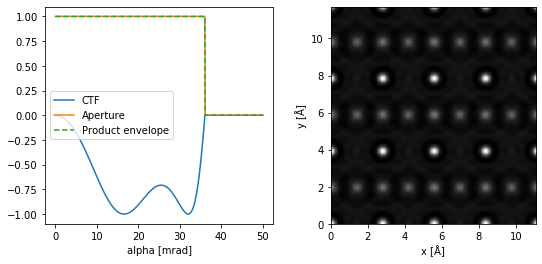

In [5]:
ctf.semiangle_cutoff = 1000 * energy2wavelength(ctf.energy) / point_resolution(ctf.Cs, ctf.energy)
print(ctf.semiangle_cutoff)

image_wave = exit_wave.apply_ctf(ctf)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(9,4))
ctf.show(50, ax=ax1)
image_wave.show(ax=ax2)

The partial coherence envelope function $E(k)$ smoothly dampens the signal of beams scattered to high angles. Its most important contribution is generally the focal spread, or, equivalently the chromatic aberration.

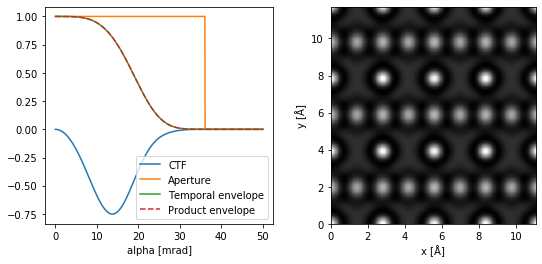

In [6]:
ctf.focal_spread = 30
image_wave2 = exit_wave.apply_ctf(ctf)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(9,4))
ctf.show(50, ax=ax1)
image_wave2.show(ax=ax2)

## Probes and CTFs

The contrast transfer function can also be calculated for a focused probe.

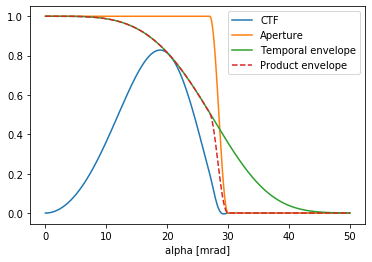

In [7]:
from abtem.waves import Probe

probe = Probe(sampling=.025, extent=10, energy=80e3, semiangle_cutoff=30, focal_spread=30, defocus=50)
probe.ctf.show(50)

We can further model the effect of different types of aberrations on our probe by changing the parameters of the contrast transfer function.

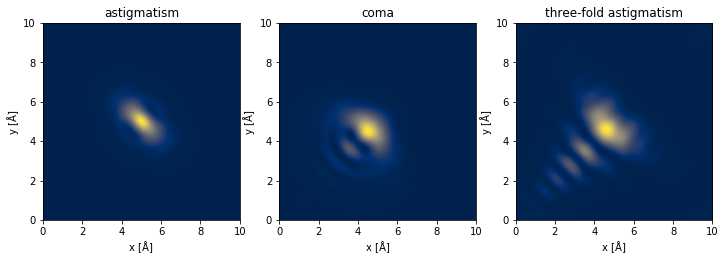

In [8]:
from copy import copy

fig, (ax1,ax2,ax3)= plt.subplots(1,3, figsize=(12,4))

probe_copy = copy(probe)
probe_copy.ctf.set_parameters({'C12': 20, 'phi12': np.pi / 4})
probe_copy.show(ax=ax1, cmap='cividis', title='astigmatism')

probe_copy = copy(probe)
probe_copy.ctf.set_parameters({'C21': 5000, 'phi21': np.pi / 4})
probe_copy.show(ax=ax2, cmap='cividis', title='coma')

probe_copy = copy(probe)
probe_copy.ctf.set_parameters({'C23': 2500, 'phi23': np.pi / 4})
probe_copy.show(ax=ax3, cmap='cividis', title='three-fold astigmatism');

## Partial coherence

The aperture function cuts off beams scattered above a certain critical angle, however it is often the partial coherence that effectively dampens the signal of beams scattered at high angles, and imposes a maximum to the transmitted spatial frequency. 


In abTEM the envelope function is constructed as a product of three envelopes

$$
    E(k) = E_s(k) E_t(k) E_d(k)
$$

Below we create a `CTF` object with all the sources of partial coeherence.

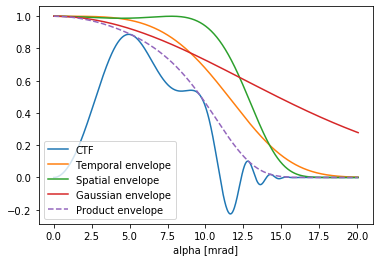

In [9]:
from abtem.transfer import CTF
from abtem.utils import energy2wavelength

ctf = CTF(energy=200e3, defocus=600, Cs=1e7, focal_spread=100, angular_spread=0.5, gaussian_spread=2)

ctf.show(.8 * energy2wavelength(200e3) * 1000)

<div class= "alert alert-info">
    
**Note: The quasi-coherent approximation**
    
Partial spatial coherence is in the contrast transfer function using the quasi-coherent approximation, where high spatial frequencies are damped using an envelope function. This approximation assumes that angular and focal spread may be summed coherently. While this approximation is efficient, the approximation may not always be appropriate.
</div>

### Partial temporal coherence
The aperture function cuts off beams scattered above a certain critical angle, however it is typically the partial coherence

A small spread in energy, $\Delta E$, of the incident electrons is equivalent to a small spread in defocus, due to the chromatic aberration of the objective lens. Fluctuations in the focusing currents, $\Delta I$, of the objective lens also produce an incoherent spread in defocus. Combining these effects, the $1/e$ width of the distribution of defocus values (the focal spread) can be written

$$
    \delta = C_c \sqrt{4 \left(\frac{\Delta I_\text{obj}}{I_\text{obj}}\right)^2 + \left(\frac{\Delta E}{V_\text{acc}}\right)^2 + \left(\frac{\Delta V_\text{acc}}{V_\text{acc}}\right)^2}
$$

The terms $\Delta I_\text{obj}/I_\text{obj}$ and $\Delta V_\text{acc}/V_\text{acc}$ represent instabilities in of the total current in the magnetic lenses and the acceleration voltage. $\Delta E/V_\text{acc}$ is the energy spread of electrons emitted by the source. Assuming that $\delta$ is small, it can be shown that focal spread can be approximated as

$$
    E_t(k) = \exp\left[-\frac{1}{2} \left(\pi \lambda \delta \right)^2 k^4 \right] .
$$

The parameter $\delta$ is equivalent to `focal_spread`.

### Partial spatial coherence
As the electron source has a finite size, the incident beam contains a distribution of incident directions. In HRTEM this is quantified by the angular spread. Assume that each incident direction performs its own experiment and that thedistribution of incident directions is small, then it can be shown that it can be modelled the spatial coherence envelope function, is given by

$$
    E_s(k) = \exp\left(-\frac{\beta}{4\lambda^2}\left| \frac{\partial \chi(k)}{\partial k}\right|^2  \right) .
$$

where $\beta$ is the $1/e$ width of the distribution of angles. The parameter $\beta$ is equivalent to `angular_spread`.

### Deflections and thermal magnetic field noise
Blurring can also be caused by all kinds of noise leading to a random deflection of the image relative to the detector, such as vibrations, drift of the stage, and magnetic noise fields resulting from eddy currents in the material of the lenses. Assuming that the image deflection is small and follows a Gaussian distribution, this can be included as an additional envelope

$$
    E_d(k) = \exp\left(- \frac{\sigma^2 k^2}{2}\right) ,
$$

where $\sigma$ is the $1/e$ width of the deflection. The parameter $\sigma$ is equivalent to the `gaussian_spread`.